In [10]:
import os

os.environ.setdefault("PYARROW_IGNORE_TIMEZONE", "1")

'1'

In [11]:
import warnings
import requests

import findspark
import numpy as np
import pyspark.pandas as ps
import pandas as pd
import seaborn as sns
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from IPython.display import display
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand
from pyspark.sql.types import FloatType, IntegerType

In [9]:
pd.set_option("display.max_rows", 1500)
ps.set_option('compute.ops_on_diff_frames', True)

In [ ]:
findspark.init()
findspark.find()

In [13]:
RESET = True
SPARK_CONNECT = False
HOST = None

if RESET:
    os.environ.pop("SPARK_REMOTE", None)
    os.environ.pop("SPARK_CONNECT_MODE_ENABLED", None)
    try:
        exec("spark.stop()")
    except Exception as e:
        print(e)

spark = None

if SPARK_CONNECT:
    HOST = "localhost"
    spark = (
        SparkSession.builder.remote("sc://localhost:15002")
        .appName("ResearchProject")
        .config("spark.driver.host", HOST)
        .config("spark.driver.port", 51041)
        .getOrCreate()
    )
else:
    HOST = "192.168.1.122"
    spark = SparkSession.builder
    spark._options.pop("spark.remote", None)
    spark = (
        spark.master("spark://localhost:7077")
        .appName("ResearchProject")
        .config("spark.driver.host", HOST)
        .config("spark.driver.port", "51041")
        .config("spark.driver.maxResultSize", "1G")
        .config("spark.driver.memory", "4G")
        .config("spark.log.level", "ERROR")
        .getOrCreate()
    )
    # make spark more efficient
    prev = spark.conf.get("spark.sql.execution.arrow.pyspark.enabled")
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")    
    ps.set_option("compute.default_index_type", "distributed")
    warnings.filterwarnings("ignore")

print(spark)

Setting Spark log level to "ERROR".


In [14]:
df = spark.read.csv(
    f"hdfs://{HOST}:8020/data/MHSVI2020_US_county.csv",
    header=True,
    encoding="ISO-8859-1",
).pandas_api()

In [15]:
head = df.head()
print(head)

  UNIQUE_ID ST    STATE ST_ABBR   COUNTY  FIPS E_TOTPOP M_TOTPOP    E_HU M_HU   E_HH  M_HH E_POV150 M_POV150 E_UNEMP M_UNEMP E_HBURD M_HBURD E_NOHSDP M_NOHSDP E_UNINSUR M_UNINSUR E_AGE65 M_AGE65 E_AGE17 M_AGE17 E_DISABL M_DISABL E_SNGPNT M_SNGPNT E_SPAN M_SPAN E_CHIN M_CHIN E_VIET M_VIET E_KOR M_KOR E_RUS M_RUS E_OTHERLANG M_OTHERLANG E_AIAN M_AIAN E_ASIAN M_ASIAN E_AFAM M_AFAM E_NHPI M_NHPI E_HISP M_HISP E_TWOMORE M_TWOMORE E_OTHERRACE M_OTHERRACE E_MUNIT M_MUNIT E_MOBILE M_MOBILE E_CROWD M_CROWD E_NOVEH M_NOVEH E_GROUPQ M_GROUPQ HOSP URG PHARM  PCP E_NOINT M_NOINT EP_POV150 MP_POV150 EP_UNEMP MP_UNEMP EP_HBURD MP_HBURD EP_NOHSDP MP_NOHSDP EP_UNINSUR MP_UNINSUR EP_AGE65 MP_AGE65 EP_AGE17 MP_AGE17 EP_DISABL MP_DISABL EP_SNGPNT MP_SNGPNT EP_SPAN MP_SPAN EP_CHIN MP_CHIN EP_VIET MP_VIET EP_KOR MP_KOR EP_RUS MP_RUS EP_OTHERLANG MP_OTHERLANG EP_AIAN MP_AIAN EP_ASIAN MP_ASIAN EP_AFAM MP_AFAM EP_NHPI MP_NHPI EP_HISP MP_HISP EP_TWOMORE MP_TWOMORE EP_OTHERRACE MP_OTHERRACE EP_MUNIT MP_MUNIT EP_

In [16]:
print(df.dtypes)

UNIQUE_ID        object
ST               object
STATE            object
ST_ABBR          object
COUNTY           object
FIPS             object
E_TOTPOP         object
M_TOTPOP         object
E_HU             object
M_HU             object
E_HH             object
M_HH             object
E_POV150         object
M_POV150         object
E_UNEMP          object
M_UNEMP          object
E_HBURD          object
M_HBURD          object
E_NOHSDP         object
M_NOHSDP         object
E_UNINSUR        object
M_UNINSUR        object
E_AGE65          object
M_AGE65          object
E_AGE17          object
M_AGE17          object
E_DISABL         object
M_DISABL         object
E_SNGPNT         object
M_SNGPNT         object
E_SPAN           object
M_SPAN           object
E_CHIN           object
M_CHIN           object
E_VIET           object
M_VIET           object
E_KOR            object
M_KOR            object
E_RUS            object
M_RUS            object
E_OTHERLANG      object
M_OTHERLANG     

In [17]:
exclude_cols = ["ST", "STATE", "ST_ABBR", "COUNTY"]

cols = [col for col in df.columns if col not in exclude_cols]

for col in cols:
    is_int = True
    for row in df[col].loc[0:5].to_list():
        is_int &= row.isdigit()
        if is_int:
            break
    if is_int:
        df[col] = df[col].astype("int64")
    else:
        df[col] = ps.to_numeric(df[col])

df = df.spark.persist()

In [18]:
df.head()


,UNIQUE_ID,ST,STATE,ST_ABBR,COUNTY,FIPS,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_SPAN,M_SPAN,E_CHIN,M_CHIN,E_VIET,M_VIET,E_KOR,M_KOR,E_RUS,M_RUS,E_OTHERLANG,M_OTHERLANG,E_AIAN,M_AIAN,E_ASIAN,M_ASIAN,E_AFAM,M_AFAM,E_NHPI,M_NHPI,E_HISP,M_HISP,E_TWOMORE,M_TWOMORE,E_OTHERRACE,M_OTHERRACE,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,HOSP,URG,PHARM,PCP,E_NOINT,M_NOINT,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,EP_HBURD,MP_HBURD,EP_NOHSDP,MP_NOHSDP,EP_UNINSUR,MP_UNINSUR,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_SPAN,MP_SPAN,EP_CHIN,MP_CHIN,EP_VIET,MP_VIET,EP_KOR,MP_KOR,EP_RUS,MP_RUS,EP_OTHERLANG,MP_OTHERLANG,EP_AIAN,MP_AIAN,EP_ASIAN,MP_ASIAN,EP_AFAM,MP_AFAM,EP_NHPI,MP_NHPI,EP_HISP,MP_HISP,EP_TWOMORE,MP_TWOMORE,EP_OTHERRACE,MP_OTHERRACE,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,R_HOSP,R_URG,R_PHARM,R_PCP,R_CARDIO,ER_DIAB,MR_DIAB,ER_OBES,MR_OBES,ER_RESPD,MR_RESPD,EP_NOINT,MP_NOINT,EPL_POV150,EPL_UNEMP,EPL_HBURD,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_UNINSUR,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,EPL_SPAN,EPL_CHIN,EPL_VIET,EPL_KOR,EPL_RUS,EPL_OTHERLANG,SPL_THEME2,RPL_THEME2,EPL_AIAN,EPL_ASIAN,EPL_AFAM,EPL_NHPI,EPL_HISP,EPL_TWOMORE,EPL_OTHERRACE,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,PL_HOSP,PL_URG,PL_PHARM,PL_PCP,SPL_THEME5,RPL_THEME5,EPL_CARDIO,EPL_DIAB,EPL_OBES,EPL_RESPD,EPL_NOINT,SPL_THEME6,RPL_THEME6,SPL_THEMES,RPL_THEMES
0,1,1,ALABAMA,AL,Autauga,1001,55639,0,23697,68,21559,366,12611,1349,736,185,5029,576,4273,562,4345,725,8490,85,13143,49,9658,856,1608,302,273,179,0,29,50,81,37,63,55,83,253,216,155,102,649,174,10849,345,0,29,1601,0,1124,374,101,145,918,292,4313,440,339,162,1167,320,578,157,1,1,10,25,7100,913,22.900000,2.4,2.9,0.7,23.299999,2.6,11.300000,1.5,8,1.3,15.3,0.2,23.600000,0.1,17.700001,1.6,7.5,1.4,0.5,0,0,0,0.1,0,0.1,0,0.1,0,0.5,0,0.3,0.2,1.2,0.3,19.500000,0.6,0,0.1,2.9,0,2,0.7,0.2,0.3,3.900000,1.2,18.200001,1.8,1.6,0.8,5.4,1.5,1,0.3,1.8,1.8,18,44.900002,282.399994,8100,3000,30500,7400,81.800003,4.4,12.900000,0,0.4624,0.1397,0.6038,0.5080,2.1725,0.3838,0.4586,0.1827,0.6986,0.6830,0.7922,0.3148,0,0.7384,0.809,0.7638,0.6146,5.5971,0.8962,0.5083,0.7139,0.8402,0,0.3297,0.4873,0.6496,3.5290,0.6722,0.6050,0.7486,0.4023,0.4764,0.1569,2.3892,0.4309,0.7005,0.2425,0.5923,0.5041,2.0394,0.4535,0.7694,0.4414,0.6325,0.8713,0.3189,3.0335,0.6831,18.760700,0.7428
1,2,1,ALABAMA,AL,Baldwin,1003,218289,0,116747,180,84047,1143,36413,2802,4027,714,19350,1526,14823,1344,20501,1932,44716,109,46993,0,30615,1565,3317,547,2595,553,184,187,94,132,16,29,215,207,629,303,1327,371,2033,352,19027,744,10,16,9947,0,4250,871,740,534,19513,979,11893,868,1280,364,2627,397,2954,403,4,7,53,150,24453,2477,16.900000,1.3,3.9,0.7,23.000000,1.8,9.500000,0.9,9,0.9,20.5,0.1,21.500000,0.0,14.200000,0.7,3.9,0.6,1.3,0,0,0,0.0,0,0.0,0,0.1,0,0.3,0,0.6,0.2,0.9,0.2,8.700000,0.3,0,0.1,4.6,0,1,0.4,0.3,0.2,16.700001,0.8,10.200000,0.7,1.5,0.4,3.1,0.5,1,0.2,1.8,3.2,24,68.699997,235.800003,8700,1800,29200,3900,54.299999,2.4,11.400000,0,0.1770,0.2861,0.5808,0.3647,1.9853,0.3253,0.5767,0.6496,0.4077,0.3689,0.1738,0.5792,0,0.0000,0.000,0.7638,0.4332,4.0306,0.6512,0.7174,0.6213,0.7307,0,0.5153,0.4449,0.7868,3.8164,0.7435,0.9574,0.4885,0.3600,0.1257,0.3157,2.2473,0.3612,0.7005,0.1146,0.2931,0.2575,1.3657,0.1165,0.4944,0.5860,0.5580,0.2997,0.2285,2.1666,0.3730,15.611900,0.3809
2,3,1,ALABAMA,AL,Barbour,1005,25026,0,12057,119,9322,338,8965,673,649,182,2305,298,4497,387,2362,311,4777,16,5222,29,4159,287,1029,217,482,199,0,23,9,18,14,28,0,23,162,134,81,63,122,25,11889,179,1,2,1110,0,334,149,157,110,170,77,3644,347,350,192,1039,202,2910,264,1,0,6,8,6249,675,40.599998,3.0,6.9,1.9,24.700001,3.1,25.299999,2.2,10,1.4,19.1,0.1,20.900000,0.1,18.799999,1.4,11.0,2.3,2.0

In [19]:
df.dtypes

UNIQUE_ID          int64
ST                object
STATE             object
ST_ABBR           object
COUNTY            object
FIPS               int64
E_TOTPOP           int64
M_TOTPOP           int64
E_HU               int64
M_HU               int64
E_HH               int64
M_HH               int64
E_POV150           int64
M_POV150           int64
E_UNEMP            int64
M_UNEMP            int64
E_HBURD            int64
M_HBURD            int64
E_NOHSDP           int64
M_NOHSDP           int64
E_UNINSUR          int64
M_UNINSUR          int64
E_AGE65            int64
M_AGE65            int64
E_AGE17            int64
M_AGE17            int64
E_DISABL           int64
M_DISABL           int64
E_SNGPNT           int64
M_SNGPNT           int64
E_SPAN             int64
M_SPAN             int64
E_CHIN             int64
M_CHIN             int64
E_VIET             int64
M_VIET             int64
E_KOR              int64
M_KOR              int64
E_RUS              int64
M_RUS              int64


In [20]:
afam_df = df[
    [
        "UNIQUE_ID",
        "ST",
        "STATE",
        "ST_ABBR",
        "COUNTY",
        "FIPS",
        "E_TOTPOP",
        "E_AFAM",
        "EP_AFAM",
        "EP_HBURD",
        "EP_NOHSDP",
        "EP_POV150",
        "EP_UNINSUR",
        "EP_DISABL",
        "EP_CROWD",
        "EP_NOINT",
        "R_HOSP",
        "R_PHARM",
        "R_URG",
        "ER_DIAB",
        "ER_RESPD",
        "ER_OBES",
        "R_CARDIO",
    ]
]

In [21]:
afam_df.head()

,UNIQUE_ID,ST,STATE,ST_ABBR,COUNTY,FIPS,E_TOTPOP,E_AFAM,EP_AFAM,EP_HBURD,EP_NOHSDP,EP_POV150,EP_UNINSUR,EP_DISABL,EP_CROWD,EP_NOINT,R_HOSP,R_PHARM,R_URG,ER_DIAB,ER_RESPD,ER_OBES,R_CARDIO
0,1,1,ALABAMA,AL,Autauga,1001,55639,10849,19.500000,23.299999,11.300000,22.900000,8,17.700001,1.6,12.900000,1.8,18,1.8,8100,81.800003,30500,282.399994
1,2,1,ALABAMA,AL,Baldwin,1003,218289,19027,8.700000,23.000000,9.500000,16.900000,9,14.200000,1.5,11.400000,1.8,24,3.2,8700,54.299999,29200,235.800003
2,3,1,ALABAMA,AL,Barbour,1005,25026,11889,47.500000,24.700001,25.299999,40.599998,10,18.799999,3.8,28.299999,4.0,24,0.0,9800,69.800003,30300,383.600006
3,4,1,ALABAMA,AL,Bibb,1007,22374,4971,22.200001,21.799999,19.100000,27.600000,9,18.100000,1.3,18.500000,4.5,22,0.0,8700,84.500000,30600,349.899994
4,5,1,ALABAMA,AL,Blount,1009,57755,771,1.300000,19.100000,17.200001,23.799999,10,15.000000,1.8,15.700000,1.7,19,0.0,9600,87.000000,27900,300.200012


In [22]:
afam_df = afam_df[afam_df["EP_AFAM"] >= 14.2]

In [23]:
afam_df.head()

,UNIQUE_ID,ST,STATE,ST_ABBR,COUNTY,FIPS,E_TOTPOP,E_AFAM,EP_AFAM,EP_HBURD,EP_NOHSDP,EP_POV150,EP_UNINSUR,EP_DISABL,EP_CROWD,EP_NOINT,R_HOSP,R_PHARM,R_URG,ER_DIAB,ER_RESPD,ER_OBES,R_CARDIO
0,1,1,ALABAMA,AL,Autauga,1001,55639,10849,19.500000,23.299999,11.300000,22.900000,8,17.700001,1.6,12.900000,1.8,18,1.8,8100,81.800003,30500,282.399994
2,3,1,ALABAMA,AL,Barbour,1005,25026,11889,47.500000,24.700001,25.299999,40.599998,10,18.799999,3.8,28.299999,4.0,24,0.0,9800,69.800003,30300,383.600006
3,4,1,ALABAMA,AL,Bibb,1007,22374,4971,22.200001,21.799999,19.100000,27.600000,9,18.100000,1.3,18.500000,4.5,22,0.0,8700,84.500000,30600,349.899994
5,6,1,ALABAMA,AL,Bullock,1011,10173,6980,68.599998,20.299999,25.100000,42.500000,10,12.300000,1.0,32.599998,9.8,29,0.0,8300,51.500000,18400,347.600006
6,7,1,ALABAMA,AL,Butler,1013,19726,8773,44.500000,20.799999,13.600000,31.600000,10,15.800000,1.1,24.100000,10.1,25,0.0,12100,75.099998,29300,309.000000


In [24]:
len(afam_df)

618

In [25]:
correlation_matrix = (
    afam_df[
        [
            "ER_DIAB",  # outcomes
            "ER_RESPD",
            "ER_OBES",
            "R_CARDIO",
            "EP_HBURD",  # factors
            "EP_NOHSDP",
            "EP_POV150",
            "EP_UNINSUR",
            "EP_DISABL",
            "EP_CROWD",
            "EP_NOINT",
            "R_HOSP",
            "R_PHARM",
            "R_URG",
        ]
    ]
    .corr()
    .to_pandas()
)

print(correlation_matrix.to_markdown())
print(type(correlation_matrix))
print(correlation_matrix["ER_DIAB"]["ER_DIAB"])

|            |     ER_DIAB |   ER_RESPD |    ER_OBES |   R_CARDIO |   EP_HBURD |   EP_NOHSDP |   EP_POV150 |   EP_UNINSUR |   EP_DISABL |    EP_CROWD |   EP_NOINT |     R_HOSP |   R_PHARM |      R_URG |
|:-----------|------------:|-----------:|-----------:|-----------:|-----------:|------------:|------------:|-------------:|------------:|------------:|-----------:|-----------:|----------:|-----------:|
| ER_DIAB    |  1          |  0.149149  |  0.71975   |  0.221805  |  0.145721  |   0.0232745 |    0.163964 |   0.00395514 |   0.0744898 | -0.00459853 | -0.0059013 |  0.0369564 | 0.0892791 |  0.0592952 |
| ER_RESPD   |  0.149149   |  1         |  0.0710869 |  0.422662  | -0.242713  |   0.304719  |    0.348916 |   0.261721   |   0.329147  | -0.021677   |  0.253984  |  0.193723  | 0.149845  | -0.0663651 |
| ER_OBES    |  0.71975    |  0.0710869 |  1         |  0.0450147 |  0.147329  |  -0.247388  |   -0.109664 |  -0.145462   |  -0.174964  | -0.0369552  | -0.275158  | -0.0866072 | 0.060873  

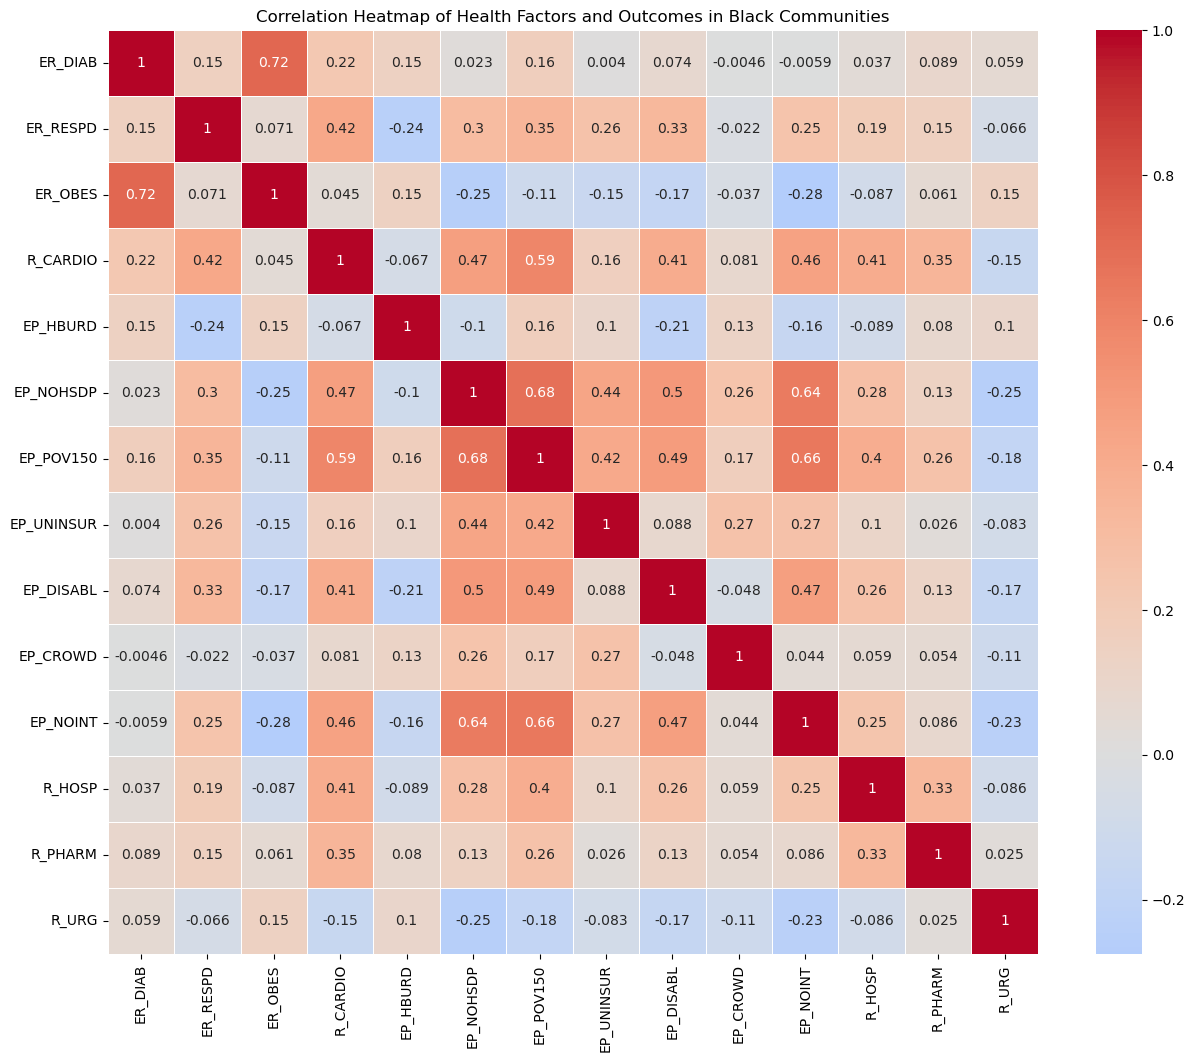

In [26]:
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0.0, linewidths=0.5)
plt.title("Correlation Heatmap of Health Factors and Outcomes in Black Communities")
plt.show()

In [27]:
percent_df = (
    df[["STATE", "E_TOTPOP", "E_AFAM"]]
    .groupby("STATE")[["E_TOTPOP", "E_AFAM"]]
    .sum()
    .reset_index()
    .to_pandas()
)
percent_df["ER_AFAM"] = percent_df["E_AFAM"] / percent_df["E_TOTPOP"]
print(percent_df.head())


                  STATE  E_TOTPOP   E_AFAM   ER_AFAM
0            NEW JERSEY   8885418  1121134  0.126177
1             WISCONSIN   5806975   360526  0.062085
2          PENNSYLVANIA  12794885  1352329  0.105693
3              ILLINOIS  12716164  1766586  0.138924
4  DISTRICT OF COLUMBIA    701974   312661  0.445403


In [28]:
diab_df = (
    afam_df[["STATE","E_AFAM","ER_DIAB"]]
    .to_pandas()
    .groupby("STATE")
    .apply(lambda x: (
        x["E_AFAM"] * x["ER_DIAB"] / 100000).sum() / x["E_AFAM"].sum()
    )
    .reset_index(name="ER_AFAM_DIAB")
)

# diab_df = (
#     afam_df[["STATE","E_AFAM","ER_DIAB"]]
#     .to_pandas()
#     .groupby("STATE")
#     .apply(lambda x: pd.Series({
#         "ER_AFAM_DIAB": (x["E_AFAM"] * x["ER_DIAB"] / 100000).sum() / x["E_AFAM"].sum(),
#         "E_AFAM": x["E_AFAM"].sum()
#     }))
#     .reset_index()
# )

print(diab_df)

                   STATE  ER_AFAM_DIAB
0                ALABAMA      0.119380
1               ARKANSAS      0.109173
2               DELAWARE      0.104665
3   DISTRICT OF COLUMBIA      0.081000
4                FLORIDA      0.092115
5                GEORGIA      0.102961
6               ILLINOIS      0.085231
7                INDIANA      0.114298
8                 KANSAS      0.118579
9               KENTUCKY      0.101615
10             LOUISIANA      0.107118
11              MARYLAND      0.106320
12         MASSACHUSETTS      0.081000
13              MICHIGAN      0.106317
14           MISSISSIPPI      0.116200
15              MISSOURI      0.094545
16            NEW JERSEY      0.085346
17              NEW YORK      0.101826
18        NORTH CAROLINA      0.093534
19                  OHIO      0.102510
20              OKLAHOMA      0.108875
21          PENNSYLVANIA      0.107417
22        SOUTH CAROLINA      0.107628
23             TENNESSEE      0.109061
24                 TEXAS 

In [29]:
respd_df = (
    afam_df[["STATE","E_AFAM","ER_RESPD"]]
    .to_pandas()
    .groupby("STATE")
    .apply(lambda x: (
        x["E_AFAM"] * x["ER_RESPD"] / 100000).sum() / x["E_AFAM"].sum()
    )
    .reset_index(name="ER_AFAM_RESPD")
)

print(respd_df)

                   STATE  ER_AFAM_RESPD
0                ALABAMA       0.000676
1               ARKANSAS       0.000651
2               DELAWARE       0.000525
3   DISTRICT OF COLUMBIA       0.000302
4                FLORIDA       0.000458
5                GEORGIA       0.000566
6               ILLINOIS       0.000437
7                INDIANA       0.000725
8                 KANSAS       0.000678
9               KENTUCKY       0.000670
10             LOUISIANA       0.000566
11              MARYLAND       0.000369
12         MASSACHUSETTS       0.000399
13              MICHIGAN       0.000554
14           MISSISSIPPI       0.000669
15              MISSOURI       0.000532
16            NEW JERSEY       0.000389
17              NEW YORK       0.000256
18        NORTH CAROLINA       0.000557
19                  OHIO       0.000581
20              OKLAHOMA       0.000787
21          PENNSYLVANIA       0.000503
22        SOUTH CAROLINA       0.000625
23             TENNESSEE       0.000556


In [30]:
obes_df = (
    afam_df[["STATE","E_AFAM","ER_OBES"]]
    .to_pandas()
    .groupby("STATE")
    .apply(lambda x: (
        x["E_AFAM"] * x["ER_OBES"] / 100000).sum() / x["E_AFAM"].sum()
    )
    .reset_index(name="ER_AFAM_OBES")
)

print(obes_df)

                   STATE  ER_AFAM_OBES
0                ALABAMA      0.346955
1               ARKANSAS      0.342176
2               DELAWARE      0.338714
3   DISTRICT OF COLUMBIA      0.239000
4                FLORIDA      0.278070
5                GEORGIA      0.300497
6               ILLINOIS      0.272883
7                INDIANA      0.358731
8                 KANSAS      0.406025
9               KENTUCKY      0.317341
10             LOUISIANA      0.320321
11              MARYLAND      0.330419
12         MASSACHUSETTS      0.213000
13              MICHIGAN      0.365346
14           MISSISSIPPI      0.358510
15              MISSOURI      0.322483
16            NEW JERSEY      0.284369
17              NEW YORK      0.256346
18        NORTH CAROLINA      0.298541
19                  OHIO      0.337258
20              OKLAHOMA      0.342564
21          PENNSYLVANIA      0.287527
22        SOUTH CAROLINA      0.332793
23             TENNESSEE      0.331074
24                 TEXAS 

In [31]:
cardio_df = (
    afam_df[["STATE","E_AFAM","R_CARDIO"]]
    .to_pandas()
    .groupby("STATE")
    .apply(lambda x: (
        x["E_AFAM"] * x["R_CARDIO"] / 100000).sum() / x["E_AFAM"].sum()
    )
    .reset_index(name="ER_AFAM_CARDIO")
)

print(cardio_df)

                   STATE  ER_AFAM_CARDIO
0                ALABAMA        0.002980
1               ARKANSAS        0.002872
2               DELAWARE        0.002230
3   DISTRICT OF COLUMBIA        0.002389
4                FLORIDA        0.002110
5                GEORGIA        0.002392
6               ILLINOIS        0.002296
7                INDIANA        0.002445
8                 KANSAS        0.002677
9               KENTUCKY        0.002315
10             LOUISIANA        0.002717
11              MARYLAND        0.002390
12         MASSACHUSETTS        0.001512
13              MICHIGAN        0.003101
14           MISSISSIPPI        0.003173
15              MISSOURI        0.002471
16            NEW JERSEY        0.002174
17              NEW YORK        0.002421
18        NORTH CAROLINA        0.002178
19                  OHIO        0.002556
20              OKLAHOMA        0.002699
21          PENNSYLVANIA        0.002520
22        SOUTH CAROLINA        0.002400
23             T

In [32]:
# Get state centroid coordinates for bubble map
STATE_COORDINATES = {
    'ALABAMA': (32.806671, -86.79113),
    'ALASKA': (61.370716, -152.404419),
    'ARIZONA': (33.729759, -111.431221),
    'ARKANSAS': (34.969704, -92.373123),
    'CALIFORNIA': (36.116203, -119.681564),
    'COLORADO': (39.059811, -105.311104),
    'CONNECTICUT': (41.597782, -72.755371),
    'DELAWARE': (39.318523, -75.507141),
    'DISTRICT OF COLUMBIA': (38.9072, -77.0369),
    'FLORIDA': (27.766279, -81.686783),
    'GEORGIA': (33.040619, -83.643074),
    'HAWAII': (21.094318, -157.498337),
    'IDAHO': (44.240459, -114.478828),
    'ILLINOIS': (40.349457, -88.986137),
    'INDIANA': (39.849426, -86.258278),
    'IOWA': (42.011539, -93.210526),
    'KANSAS': (38.5266, -96.726486),
    'KENTUCKY': (37.66814, -84.670067),
    'LOUISIANA': (31.169546, -91.867805),
    'MAINE': (44.693947, -69.381927),
    'MARYLAND': (39.063946, -76.802101),
    'MASSACHUSETTS': (42.230171, -71.530106),
    'MICHIGAN': (43.326618, -84.536095),
    'MINNESOTA': (45.694454, -93.900192),
    'MISSISSIPPI': (32.741646, -89.678696),
    'MISSOURI': (38.456085, -92.288368),
    'MONTANA': (46.921925, -110.454353),
    'NEBRASKA': (41.12537, -98.268082),
    'NEVADA': (38.313515, -117.055374),
    'NEW HAMPSHIRE': (43.452492, -71.563896),
    'NEW JERSEY': (40.298904, -74.521011),
    'NEW MEXICO': (34.840515, -106.248482),
    'NEW YORK': (42.165726, -74.948051),
    'NORTH CAROLINA': (35.630066, -79.806419),
    'NORTH DAKOTA': (47.528912, -99.784012),
    'OHIO': (40.388783, -82.764915),
    'OKLAHOMA': (35.565342, -96.928917),
    'OREGON': (44.572021, -122.070938),
    'PENNSYLVANIA': (40.590752, -77.209755),
    'RHODE ISLAND': (41.680893, -71.51178),
    'SOUTH CAROLINA': (33.856892, -80.945007),
    'SOUTH DAKOTA': (44.299782, -99.438828),
    'TENNESSEE': (35.747845, -86.692345),
    'TEXAS': (31.054487, -97.563461),
    'UTAH': (40.150032, -111.862434),
    'VERMONT': (44.045876, -72.710686),
    'VIRGINIA': (37.769337, -78.169968),
    'WASHINGTON': (47.400902, -121.490494),
    'WEST VIRGINIA': (38.491226, -80.954063),
    'WISCONSIN': (44.268543, -89.616508),
    'WYOMING': (42.755966, -107.30249)
}


In [33]:
def save_map(df: pd.DataFrame, variable: str, scale: int) -> folium.Map:

    global STATE_COORDINATES

    # Load the US states shapefile
    us_states = gpd.read_file(
        "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
    ).rename(columns={"name": "STATE"})

    us_states["STATE"] = us_states["STATE"].str.upper()

    # Initialize the map centered on the US
    m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

    title_html = f'<h1 style="position:absolute;z-index:100000;left:40vw" >{variable}</h1>'
    m.get_root().html.add_child(folium.Element(title_html))    

    # Add a heat map layer
    folium.Choropleth(
        geo_data=us_states,
        name="choropleth",
        data=percent_df,
        columns=["STATE", "ER_AFAM"],
        key_on="feature.properties.STATE",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="African American Population Percentage",
    ).add_to(m)


    df["LAT"] = df["STATE"].apply(lambda x: STATE_COORDINATES[x][0])
    df["LON"] = df["STATE"].apply(lambda x: STATE_COORDINATES[x][1])

    for _, row in df.iterrows():
        percentage = 100 * row[variable]
        state = row["STATE"]
        folium.CircleMarker(
            location=[row["LAT"], row["LON"]],
            radius=row[variable] * scale,  # Adjust size as needed
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=f"{variable} {percentage:.2f}% {state}",
        ).add_to(m)

    # Save the map as an HTML file
    m.save(f"./results/{variable}.html")

    return m


In [39]:
outcomes = [
    (respd_df, "ER_AFAM_RESPD", 10000),
    (cardio_df, "ER_AFAM_CARDIO", 3000),
    (diab_df, "ER_AFAM_DIAB", 1000),
    (obes_df, "ER_AFAM_OBES", 1000),
]

for df, variable, map_scale in outcomes:
    m = save_map(df, variable, map_scale)
    display(m)
    output_path = f"hdfs://{HOST}:8020/results/{variable}"
    _df = ps.from_pandas(df)
    _df.to_csv(output_path, mode="overwrite")

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 2]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 